In [1]:
from IPython.display import clear_output
!pip install paddle-quantum
!pip install qiskit
!pip install qiskit_dynamics
# !pip install qiskit-experiments
clear_output()

In [2]:
import qiskit
import numpy as np
from qiskit.circuit import Gate
from qiskit.pulse import library, Schedule,GaussianSquare, ControlChannel, Play, Drag,DriveChannel,Delay,DriveChannel, SymbolicPulse, ShiftPhase
from qiskit.pulse import transforms
from qiskit.pulse.transforms import block_to_schedule,remove_directives
from qiskit.pulse import filters
from qiskit.pulse.filters import composite_filter, filter_instructions
from typing import List, Tuple, Iterable, Union, Dict, Callable, Set, Optional, Any
from qiskit.visualization.pulse_v2 import draw, IQXSimple,IQXDebugging
from qiskit import IBMQ
import copy
from qiskit.circuit.parameterexpression import ParameterValueType
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit import pulse, QuantumCircuit, IBMQ, visualization,execute, Aer
from qiskit.pulse import library
from qiskit.visualization.pulse_v2.stylesheet import IQXDebugging
from qiskit.visualization.pulse_v2 import draw
from qiskit.providers.fake_provider import *
from qiskit.pulse import transforms
from qiskit.pulse.transforms import block_to_schedule
from qiskit.pulse import filters
from qiskit.pulse.filters import composite_filter, filter_instructions
from typing import List, Tuple, Iterable, Union, Dict, Callable, Set, Optional, Any
from qiskit.pulse.instructions import Instruction
from qiskit.compiler import assemble, schedule
from qiskit.providers.aer.pulse import PulseSystemModel
from qiskit.providers.aer import PulseSimulator
from qiskit_dynamics import Solver, DynamicsBackend
from qiskit_dynamics.backend import default_experiment_result_function
from qiskit_dynamics.array import Array
import jax

In [4]:
import pickle

In [5]:
import qiskit.quantum_info as qi

In [6]:
import random
import decimal
import numpy as np
import paddle
import paddle_quantum as pq
from paddle_quantum.ansatz.circuit import Circuit
from paddle_quantum.visual import plot_state_in_bloch_sphere

/usr/local/lib/python3.9/dist-packages/openfermion/hamiltonians/hartree_fock.py:11: DeprecationWarning: Please use `OptimizeResult` from the `scipy.optimize` namespace, the `scipy.optimize.optimize` namespace is deprecated.
  from scipy.optimize.optimize import OptimizeResult
/usr/local/lib/python3.9/dist-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:


In [7]:
backend = FakeQuito()

backend.configuration().hamiltonian['qub']

backend.configuration().hamiltonian['qub'] = {'0': 2,'1': 2,'2': 2,'3': 2,'4': 2 }
backend_model = PulseSystemModel.from_backend(backend)
backend_sim = PulseSimulator(system_model=backend_model)
backend_config = backend.configuration().to_dict()
num_qubits = int(backend_config['n_qubits'])
f = backend.properties().frequency
freq = [f(i) for i in range(num_qubits)]
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")

Array.set_default_backend("jax")


<ipython-input-7-0d6b50dddf13>:7: DeprecationWarning: The Pulse simulator backend in Qiskit Aer is deprecated and will be removed in a future release. Instead the qiskit-dynamics library should be used instead for simulating at the pulse level.
  backend_sim = PulseSimulator(system_model=backend_model)


Statevector Calculation

In [10]:
def new_experiment_result_function(
    experiment_name,
    solver_result,
    measurement_subsystems,
    memory_slot_indices,
    num_memory_slots,
    backend,
    seed,
    metadata,
):
    result = default_experiment_result_function(
        experiment_name,
        solver_result,
        measurement_subsystems,
        memory_slot_indices,
        num_memory_slots,
        backend,
        seed,
        metadata,
    )
    
    result.statevector = solver_result.y[-1]
    return result

Prepare Pulse

In [9]:
def drag_pulse(backend, amp, angle):
  backend_defaults = backend.defaults()
  inst_sched_map = backend_defaults.instruction_schedule_map 
  x_pulse = inst_sched_map.get('x', (0)).filter(channels = [DriveChannel(0)], instruction_types=[Play]).instructions[0][1].pulse
  duration_parameter = x_pulse.parameters['duration']
  sigma_parameter = x_pulse.parameters['sigma']
  beta_parameter = x_pulse.parameters['beta']
  pulse1 = Drag(duration=duration_parameter, sigma=sigma_parameter, beta=beta_parameter, amp=amp, angle=angle)
  return pulse1

def cr_pulse(backend, amp, angle, duration):
  backend_defaults = backend.defaults()
  inst_sched_map = backend_defaults.instruction_schedule_map 
  cr_pulse = inst_sched_map.get('cx', (0, 1)).filter(channels = [ControlChannel(0)], instruction_types=[Play]).instructions[0][1].pulse
  cr_params = {}
  cr_params['duration'] = cr_pulse.parameters['duration']
  cr_params['amp'] = cr_pulse.parameters['amp']
  cr_params['angle'] = cr_pulse.parameters['angle']
  cr_params['sigma'] = cr_pulse.parameters['sigma']
  cr_params['width'] = cr_pulse.parameters['width']
  cr_risefall = (cr_params['duration'] - cr_params['width']) / (2 * cr_params['sigma'])
  angle_parameter = angle
  duration_parameter =  duration
  sigma_parameter = cr_pulse.parameters['sigma']
  width_parameter = int(duration_parameter - 2 * cr_risefall * cr_params['sigma'])
  #declare pulse parameters and build GaussianSquare pulse
  pulse1 = GaussianSquare(duration = duration_parameter, amp = amp, angle = angle_parameter, sigma = sigma_parameter, width=width_parameter)
  return pulse1

def block_pulse2q(backend, amp, angle, width):
    with pulse.build(backend) as my_program1:
      # layer 1
      sched_list = []
      with pulse.build(backend) as sched1:
          for i in range(2):
              pulse.play(drag_pulse(backend, amp[i], angle[i]), DriveChannel(i))
      sched_list.append(sched1)

      with pulse.build(backend) as sched2: #这里control channel可以根据目标改一下
          uchan = pulse.control_channels(0, 1)[0]
          pulse.play(cr_pulse(backend, amp[2], angle[2], width[0]), uchan)
      sched_list.append(sched2)
      
      with pulse.build(backend) as sched3:
          qubits = (0,1)
          for i in qubits:
              pulse.play(drag_pulse(backend, amp[2+i], angle[2+i]), DriveChannel(i))
      sched_list.append(sched3)

      with pulse.build(backend) as sched4:
          uchan = pulse.control_channels(0, 1)[0]
          pulse.play(cr_pulse(backend, amp[5], angle[5], width[1]), uchan)
      sched_list.append(sched4)

      with pulse.build(backend) as sched5:
          qubits = (0,1)
          for i in qubits:
              pulse.play(drag_pulse(backend, amp[5+i], angle[5+i]), DriveChannel(i))
      sched_list.append(sched5)

      with pulse.build(backend) as my_program:
        with pulse.transpiler_settings(initial_layout= [0,1]):
          with pulse.align_sequential():
              for sched in sched_list:
                  pulse.call(sched)
              pulse.measure(qubits)

    return my_program

Calculate Entanglement Capability

In [11]:
import paddle
import paddle_quantum as pq
from paddle_quantum.ansatz.circuit import Circuit
from paddle_quantum.qinfo import state_fidelity, partial_trace, purity
import warnings
import qiskit.quantum_info as qi
import random
import decimal
import numpy as np
import paddle
import paddle_quantum as pq
from paddle_quantum.ansatz.circuit import Circuit
from paddle_quantum.visual import plot_state_in_bloch_sphere
from paddle_quantum.linalg import haar_unitary
from paddle_quantum.qinfo import state_fidelity
from paddle_quantum.state.common import to_state
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy import integrate

In [13]:
backend_run = DynamicsBackend.from_backend(backend, evaluation_mode="sparse")
solver_options = {"method": "jax_odeint", "atol": 1e-6, "rtol": 1e-8}

backend_run.set_options(solver_options=solver_options,experiment_result_function=new_experiment_result_function)
backend_run.configuration = lambda: backend.configuration()
outputs_mix = list()   
num_sample = 500
ent_list = []
amp_list = []
ang_list = []
duration_list = []
for _ in range(num_sample):

  amp = [float(decimal.Decimal(random.randrange(0, 1000))/1000) for _ in range(7)]
  ang = [2*np.pi*float(decimal.Decimal(random.randrange(0, 1000))/1000) for _ in range(7)]
  duration = [random.randrange(256, 1024, 16) for _ in range(2)]
  # generate new parametrized pulse
  firstlayer = block_pulse2q(backend,amp, ang,duration)
  # set up pulse schedule
#    cirq_gates = assemble(firstlayer,
#                      backend=backend_sim,
#                      qubit_lo_freq=freq,
#                      meas_level=2,
#                      meas_return='avg',
#                      shots=2048)

  results = backend_run.run(firstlayer, meas_level = 2).result()
  # Returen the density matrix of q0
  vec = results.results[0].statevector
  # print(len(vec))
  rho1 = qi.partial_trace(vec, [1,2,3,4])
  rho2 = qi.partial_trace(vec, [0,2,3,4])

  #p = (rho1.purity() + rho2.purity() + rho3.purity() + rho4.purity())/4
#    p = (qi.purity(rho1) + qi.purity(rho2))/2
  p = (rho1.purity() + rho2.purity())/2
  # Calculate Q
  Q =2*(1-p)
  ent_list.append(Q)
  ang_list.append(ang)
  amp_list.append(amp)
  duration_list.append(duration)

Ent = sum(ent_list)/num_sample
print("Eantangling Capability for this PQC is: {0:.6f}".format(Ent))

Eantangling Capability for this PQC is: 0.200160+0.000000j


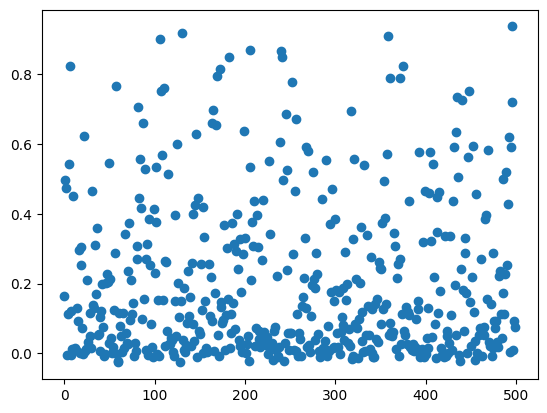

In [14]:
import matplotlib.pyplot as plt

data = ent_list

real_data = [x.real for x in data]

plt.scatter(range(len(real_data)), real_data)
plt.show()